# General Index Labeling Test
Small scale testing of general index data & processing

---
Created 6/14/22 by Ian Hay

### Imports

In [1]:
from time import time
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from timeit import Timer
from pyvis.network import Network
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.preprocessing import StandardScaler

### Functions

In [2]:
# Utility --------------------------------------------------------------------------------------------------

def loadTextFileIntoDataframe(filepath, splittingChar="\t"):
    """
    Opens the given filepath into a pandas dataframe.
    Splits the list by the denoted character, by default tab.
    Returns a pandas dataframe.
    """
    with open(filepath) as file:
        data = file.readlines()
    df = pd.DataFrame()
    for line in data:
        lineSplit = line.split(splittingChar)
        df = df.append([lineSplit])
    return df

def numSimilarStrings(stringList1, stringList2):
    """
    Given two lists of strings, returns the number of strings they both share.
    In other words, the size of the subset intersection of stringList1 and stringList2.
    """

    # is there a faster way to do this with sets?

    count = 0
    for string in stringList1:
        if string in stringList2:
            count = count + 1
    return count

def standardizeDataColumn(df, column, newColumnName):
    """
    Standardizes the column of the dataframe df.
    Adds the new column newColumnName to the dataframe inplace.
    Utilizes SKLearn.preprocessing.standardscaler.
    Mean is 0, variance is 1
    """
    scaler = StandardScaler()
    scaledSeries = pd.Series(np.reshape(scaler.fit_transform(np.array(df[column]).reshape(-1, 1)), (-1)))
    for n in range(len(df)):
        df[newColumnName][n] = scaledSeries[n] + 1 # scales most (~98%) to be in range [0, 2] for graphing purposes
    

def subtractListsOfInts(_list1, _list2):
    """
    Given two lists of items, returns a list of items
    in _list1 and not in _list2.
    Utilizes collections.Counter
    Returns a list of items.

    https://stackoverflow.com/questions/2070643/subtracting-two-lists-in-python
    """
    _set1 = Counter(_list1)
    _set2 = Counter(_list2)
    _set1_2 = _set1 - _set2
    return list(_set1_2.elements())

# To Do:
#   - Performance Testing
def getUniqueWordsColumn(df, column, newColumnName, nonWords=[]):
    """
    Given a dataframe and column, constructs a new column with name newColumnName
    of the unique words in  df[column].
    The object in  df[column]  must be a list of strings.
    Returns the updated dataframe.
    """
    df[newColumnName] = df[column]
    for row in range(len(df[newColumnName])):
        df[newColumnName][row] = df[column].iloc[row]
        string_list = []
        for string in df[newColumnName].iloc[row]:
            string_list.append(string.split(" ")) # splits words into list of individual word strings
        string_list = list(itertools.chain(*string_list)) # concatenates nested list into 1D list
        string_list = list(set(string_list)) # grabs only unique string items
        for nonword in nonWords:
            if nonword in string_list:
                string_list.remove(nonword)
        df[newColumnName].iloc[row] = string_list
    return df


# performance building adjMatrix on combined test set (n=768 rows/papers):
# * time for 100 iterations:  430.5321 seconds
# *     time per iteration: 4.305321 seconds
#
# *: timed on 16-thread CPU
def buildAdjacencyMatrixByColumn(df, column):
    """
    Given a dataframe and a column, constructs an adjacency matrix
    of size [n x n] where  n  is the number of rows of the dataframe.
    The adjacency matrix represents the number of alike elements.
    The object in  df[column]  must be a list of values.
    """
    n = len(df[column])
    adjMatrix = np.zeros((n, n))
    for n1 in range(n):
        ngram1 = df[column].iloc[n1]
        for n2 in range(n):
            ngram2 = df[column].iloc[n2]
            numSimilar = numSimilarStrings(ngram1, ngram2)
            adjMatrix[n1][n2] = numSimilar
            if n1 == n2:
                adjMatrix[n1][n2] = 0 # removes recursive edges
            if numSimilar == 1:
                adjMatrix[n1][n2] = 0 # removes edges with 1 similarity to reduce complexity
    
    # consider removing rows&columns with no connections
    # (or adding an option to)
    
    return adjMatrix


In [3]:
# Visualization -------------------------------------------------------------------------------------------

def visualizeNetworkHTML(_graph, _filename, _width="1920px", _height="1080px", _physics=False):
    """
    Given a NetworkX graph and the filename to save to, builds an HTML
    graph of that network. Optional parameters are width and height of graph.
    Uses pyvis to build an interactive HTML graph of a NetworkX graph.
    Uses NetworkX for graph storage.
    """
    _net = Network(width=_width, height=_height, notebook=True)
    _net.toggle_physics(_physics)
    _net.barnes_hut()
    _net.from_nx(_graph)
    _net.show(_filename)

def plot_top_words_one_topic(model, feature_names, n_top_words, title):
    """
    """
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        plt.barh(top_features, weights, height=0.7)
        plt.tick_params(axis="both", which="major", labelsize=20)
        plt.suptitle(title, fontsize=25)
    plt.show()

def plot_top_words(model, feature_names, n_top_words, title, n_topics):
    """
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    fig, axes = plt.subplots(1, n_topics, figsize=(15, 7), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

### Building Dataframe

In [4]:
# hard coded things
columnDict = {0: "hash", 1: "ngram", 2: "ngram_lc", 3: "ngram_num_tokens", 4: "ngram_count", 5: "term_freq", 6: "doc_count"}
non_words = ["a", "at", "an", "am", "and", "that", "like", "for", "by", "i", "in", "of", "or", "be", "use", "as", "on", "the", "to", "with", "-pron-"]

In [5]:
# load test files into dataframe
filenameAnte = "data/doc_ngrams/sample.fgrep.antediluvian.txt"
filepathHennig = "data/doc_ngrams/sample.fgrep.Hennig86.txt"

df_antedivulian = loadTextFileIntoDataframe(filepath=filenameAnte)
df_hennig = loadTextFileIntoDataframe(filepath=filepathHennig)
df = pd.concat([df_antedivulian, df_hennig])
df.drop(7, axis=1, inplace=True)
df.rename(columns=columnDict, inplace=True)
df = df.groupby("hash").agg(list)

for n in range(len(df)):
    term_freq_list = df["term_freq"].iloc[n]
    df["term_freq"][n] = term_freq_list[0]
df["term_freq"] = df["term_freq"].astype(float)

df = getUniqueWordsColumn(df, "ngram_lc", "ngram_words", nonWords=non_words)
df["normalized_term_freq"] = np.zeros(len(df))
standardizeDataColumn(df, "term_freq", "normalized_term_freq")
df.head()

<ipython-input-2-da391d032a99>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[newColumnName][row] = df[column].iloc[row]
c:\Users\ianha\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-2-da391d032a99>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[newColumnName][n] = scaledSeries[n] + 1 # scales most (~98%) to be 

,ngram,ngram_lc,ngram_num_tokens,ngram_count,term_freq,doc_count,ngram_words,normalized_term_freq
hash,,,,,,,,
3002e8a37ec9d00a67bdf0004b8628c35d72068d,"[antediluvian, antediluvian humanity]","[antediluvian, antediluvian humanity]","[1, 2]","[1, 1]",0.000010,"[1, 1]","[humanity, antediluvian]",0.345035
3005b3bf055ddcb3c25e4742a72ee16728934efd,"[antediluvian, antediluvian refrain, follow by...","[antediluvian, antediluvian refrain, follow by...","[1, 2, 4, 5]","[1, 1, 1, 1]",0.000281,"[1, 1, 1, 1]","[refrain, antediluvian, follow]",0.995948
3005ebfe5508340797dbfcce8454f3d3f6f76eb1,"[antediluvian, antediluvian dream, cave of -PR...","[antediluvian, antediluvian dream, cave of -pr...","[1, 2, 4, 5, 5]","[1, 1, 1, 1, 1]",0.000091,"[1, 1, 1, 1, 1]","[mammoth, antediluvian, dream, cave]",0.540615
30064ae161de1e9a96992be108c195796f13e72a,"[Hennig86 program, routine in the Hennig86, ro...","[hennig86 program, routine in the hennig86, ro...","[2, 4, 5, 1]","[1, 1, 1, 1]",0.000198,"[1, 1, 1, 1]","[routine, hennig86, program]",0.797378
30136ab3788ab8e8be6b939901ec669a41ef896a,[antediluvian],[antediluvian],[1],[1],0.000051,[1],[antediluvian],0.443641


In [6]:
df.shape

(768, 8)

### Performance Testing

In [7]:
# t = Timer("buildAdjacencyMatrixByColumn(df, \"ngram_words\")", "from __main__ import buildAdjacencyMatrixByColumn, df")
# t.timeit(number=100)

### Building Network and Community Partitioning

In [8]:
# initial community partition on all data

# column to build adajency matrix 
adjColumnName = "ngram_words"

print("Building Adjacency Matrix...")
t0 = time()
adjMatrix = buildAdjacencyMatrixByColumn(df, adjColumnName)
print("Done in %0.3fs.\n" % (time() - t0))

print("Building Networkx Graph...")
t0 = time()
G = nx.from_numpy_array(adjMatrix)
print("Done in %0.3fs.\n" % (time() - t0))

community_generator = nx.algorithms.community

print("Building Louvain Partitions...")
t0 = time()
community_sets = community_generator.louvain_communities(G, resolution=0.1)
print("Done in %0.3fs.\n" % (time() - t0))


numCommunities = 0
numNodes = len(adjMatrix[0])
nodes = list(range(numNodes))
scalingFactor = 5. # scales the node size for visibility

node_to_community = {}

for set in community_sets:
    for x in set:
        node_to_community[x] = numCommunities
    numCommunities = numCommunities + 1

print("Adding Node Metadata...")
t0 = time()
for n in nodes:
    # 'title': hash (i.e. dataframe index)
    # 'group': partition
    # 'label': topic (empty for now)
    # 'size': normalized YAKE score
    G.nodes[n]["title"] = df.index[n]
    G.nodes[n]["group"] = node_to_community[n]
    G.nodes[n]["size"] = df["normalized_term_freq"][n] * scalingFactor
print("Done in %0.3fs.\n" % (time() - t0))

Building Adjacency Matrix...
Done in 4.275s.

Building Networkx Graph...
Done in 0.020s.

Building Louvain Partitions...
Done in 0.063s.

Adding Node Metadata...
Done in 0.005s.



In [9]:
# remove nodes apart of sparse communities

community_sets_pared = []
X = 3

for com in community_sets:
    if (len(com) < X): # bypasses communities with fewer than X nodes
        continue
    else:
        community_sets_pared.append(com)

nodes_to_keep = list(itertools.chain(*community_sets_pared))

print("Adjacency Matrix size before: " + str(adjMatrix.shape))
adjMatrixReduced = (adjMatrix[nodes_to_keep].T)[nodes_to_keep].T  # https://stackoverflow.com/questions/22927181/selecting-specific-rows-and-columns-from-numpy-array
print("Adjacency Matrix size after: " + str(adjMatrixReduced.shape) + "\n")

nodes_to_remove = subtractListsOfInts(nodes, nodes_to_keep)

print("Removing Nodes...")
t0 = time()
G.remove_nodes_from(nodes_to_remove)
print("Done in %0.3fs.\n" % (time() - t0))

numCommunities = len(community_sets_pared)

Adjacency Matrix size before: (768, 768)
Adjacency Matrix size after: (582, 582)

Removing Nodes...
Done in 0.000s.



### Topic Extraction

Building Corpus...
done in 0.085s.

Fitting Corpus...
done in 2.253s.



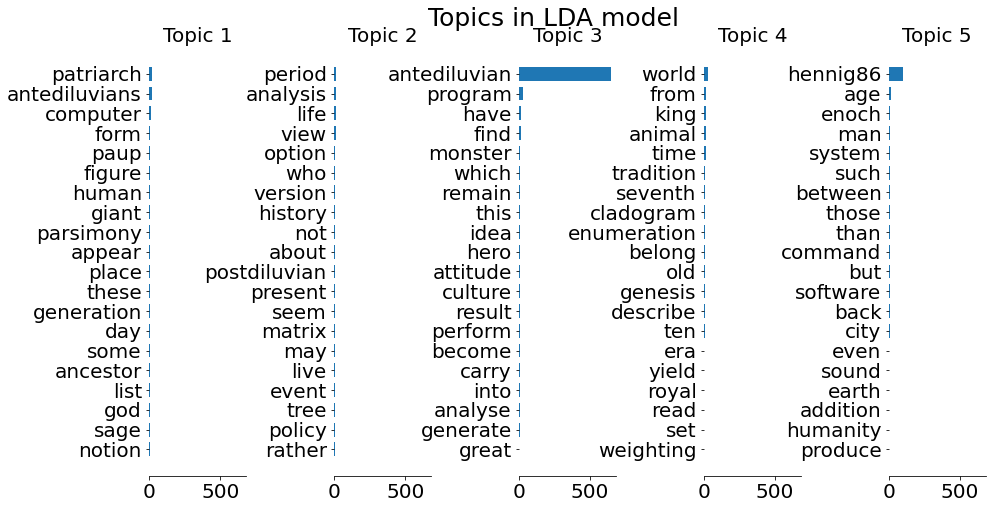

In [10]:
# on the whole data
vectorizer = CountVectorizer()
lda = LDA(n_components=numCommunities)

doc = []

print("Building Corpus...")
t0 = time()
for hash in df.index:
    hashDoc = df.loc[hash][adjColumnName]
    doc.append(hashDoc)
doc = list(itertools.chain(*doc)) # concatenates nested list into 1D list
X = vectorizer.fit_transform(doc).toarray() # sparse matrix of token counts
print("done in %0.3fs.\n" % (time() - t0))

print("Fitting Corpus...")
t0 = time()
lda.fit(X)
print("done in %0.3fs.\n" % (time() - t0))

cols = vectorizer.get_feature_names_out()
plot_top_words(lda, cols, n_top_words=20, title="Topics in LDA model", n_topics=numCommunities)

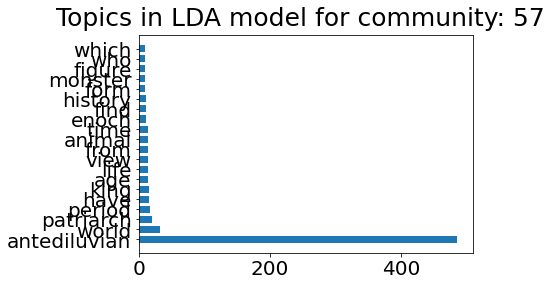

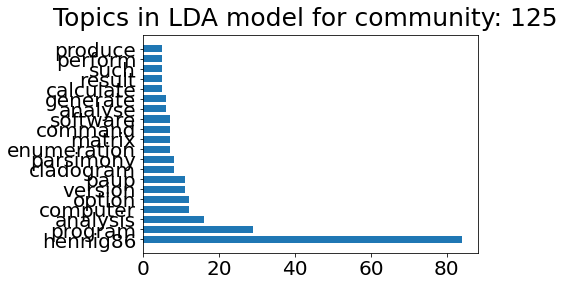

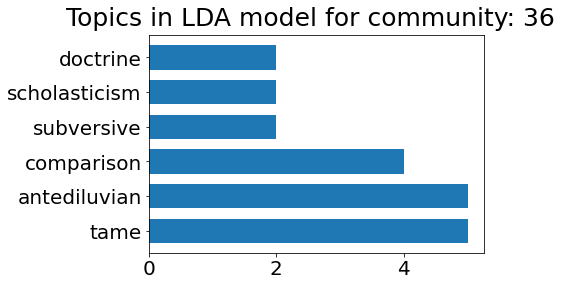

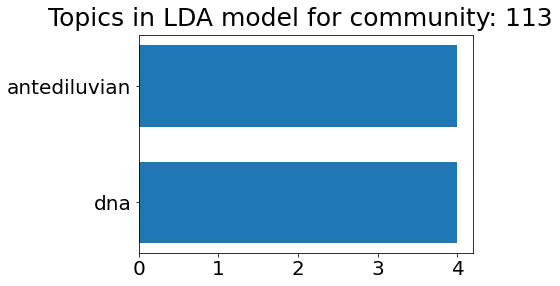

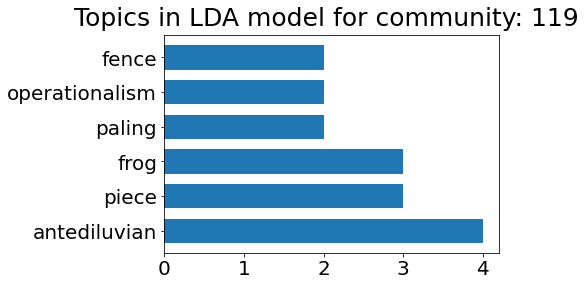

In [11]:
# on partitions of data

def filterNode(n1):
    return n1 in nodesInGroup

vectorizer = CountVectorizer()
numTopics = 1 # number of topics to pull out for each community

groupDict = nx.get_node_attributes(G, "group")
groupList = list(Counter(list(nx.get_node_attributes(G, "group").values())))

for community in groupList:

    # get the community's nodes
    nodesInGroup = [n for n in G.nodes if groupDict.get(n, "group")==community]
    subgraph = nx.subgraph_view(G, filter_node=filterNode)
    subgraphHashes = list(nx.get_node_attributes(subgraph, "title").values())

    # build the doc
    doc = []
    
    for hash in subgraphHashes:
        hashDoc = df.loc[hash][adjColumnName]
        doc.append(hashDoc)

    # fit the model
    doc = list(itertools.chain(*doc)) # concatenates nested list into 1D list
    X = vectorizer.fit_transform(doc).toarray() # sparse matrix of token counts

    lda = LDA(n_components=numTopics)
    lda.fit(X)

    # add label to nodes
    cols = vectorizer.get_feature_names_out()
    feats = lda.components_[0]
    featDict = dict(zip(cols, feats))
    nodeLabel = max(featDict, key=featDict.get)
    for n in nodesInGroup:
        G.nodes()[n]["label"] = nodeLabel

    # plot the topic
    plot_top_words_one_topic(lda, cols, n_top_words=20, title=f"Topics in LDA model for community: {community}")

### Visualizations

In [13]:
visualizeNetworkHTML(G, _filename="test labeling.html", _width="3840px", _height="2160px", _physics=True)